In [2]:
%run utils.ipynb
import spacy
from spacy import displacy
import nltk
import torch
from supar import Parser
import math
from thinc.api import set_gpu_allocator, require_gpu
set_gpu_allocator("pytorch")
require_gpu(0)

True

In [3]:
loader = DataLoader()
d = loader.GetData('final')['text']

In [ ]:
for text in d:
    for i in range(len(text)-1):
        if len(text) < 10:
            break
        if text[i] == "'" and text[i+1].isalpha() and text[i+1] not in ['t','s','d'] and text[i-1].isalpha() and text[i-1] not in ['I']:
            if i < len(text) -10 :
                print(text[i-10:i+10])
            elif i <10:
                print(text[:10])
            else:
                print(text[i-10:])

In [4]:
NLP = spacy.load('en_core_web_trf')
SuPar = Parser.load('crf-con-en')

In [6]:
for i in range(len(d)):
    d.iloc[i] = d.iloc[i].replace("'","' ")

In [3]:
#doc = NLP(d.iloc[0])
doc = NLP('I drank a cup of water that has some juice in it.')

In [9]:
s = [[token.text for token in sent if token.text] for sent in list(doc.sents)]

In [11]:
list(doc.sents)[0]

I drank a cup of water that has some juice in it.

In [13]:
sent_trees = str(SuPar.predict(s[0],prob=True,verbose= False).sentences[0])
sent_trees

'(TOP (S (NP (_ I)) (VP (_ drank) (NP (NP (_ a) (_ cup)) (PP (_ of) (NP (_ water))) (SBAR (WHNP (_ that)) (S (VP (_ has) (NP (_ some) (_ juice)) (PP (_ in) (NP (_ it)))))))) (_ .)))'

In [14]:
a = nltk.Tree.fromstring(sent_trees)

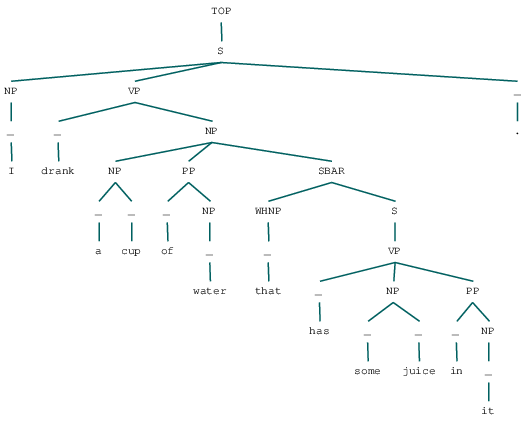

In [15]:
a

In [5]:
d[20]

'To begin with,talking to your friends about your problems may be agood idea.Friends are the same as us in many perspectives.As a result,they can considerate in our shoes and help us solve the trouble.More importantly,we should tell adults surround by about our homesickness.To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.As a consequence,they will show empassy to us and think in our way.Besides,reading some book about overcoming homesickness is also a fantastic way to deal with this problem.For examble,we can learn some physiological hints that can give us some belongings.Last but not least,I think the root to solve this problem is overcome our thoughts in our heart.We feel homesickness because of our feeling of alone.But if our hearts become hard,we can be immunity to homesickness. '

In [6]:
def CreateTree(token):
    if token.n_lefts == 0 and token.n_rights == 0:
        return nltk.Tree('_'.join([token.text,token.dep_]),[])
    else:    
        return nltk.Tree('_'.join([token.text,token.dep_]),[CreateTree(child) for child in token.children])

In [7]:
doc = NLP(d[20])

In [8]:
t = CreateTree(list(doc.sents)[0].root)

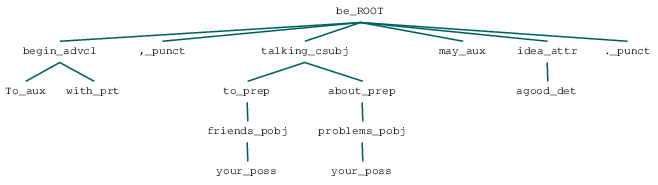

In [9]:
t

In [65]:
for token in list(doc.sents)[0]:
    print(token,token.dep_,list(token.children))

To aux []
begin advcl [To, with]
with prt []
, punct []
talking csubj [to, about]
to prep [friends]
your poss []
friends pobj [your]
about prep [problems]
your poss []
problems pobj [your]
may aux []
be ROOT [begin, ,, talking, may, idea, .]
agood det []
idea attr [agood]
. punct []


In [59]:
[t[i].label() for i in range(len(t))]

['begin_advcl', ',_punct', 'talking_csubj', 'may_aux', 'idea_attr', '._punct']

if labels of $n_1$ and $n_2$ are the same:
$$
C(n_1,n_2) = 1 + \sum_{J_1,J_2,|J_1| = |J_2|}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}])
$$
we are summing over all pairs of possible subsequences of children of all possible length (smaller than shorter tree length), allowing partial trees with gaps   
With decay factors:
$$
C(n_1,n_2) = \mu (\lambda^2 + \sum_{J_1,J_2,|J_1| = |J_2|} \lambda^{(d(J_1)+d(J_2))}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}]))
$$
where
$$
d(J_1) = J_{1l(J_1)} - J_{1i} + 1
$$
if they are different:
$$
C(n_1,n_2) = 0
$$
The tree kernel of $T_1$ and $T_2$ is:
$$
K(T_1,T_2) = \sum_{t_1\in N_{T_1}}\sum_{t_2\in N_{T_2}}C(t_1,t_2)
$$
with normalization
$$
K_{norm}(T_1,T_2) = \dfrac{K(T_1,T_2)}{\sqrt{K(T_1,T_1) \times K(T_2,T_2)}}
$$

In [228]:
import math
def GetAllComb(n,NumList):
    # Get all subsets of length n in the given list, and in the original order
    res = []
    if n == 1: # [0,1,2] --> [[0],[1],[2]]
        return [[i] for i in NumList]
    if n == len(NumList): # [0,1,2] --> [0,1,2]
        return [[i for i in NumList]]
    if n >= 2: # for each element before len(NumList)-n, insert that element into position 0 for all subsets of length n-1 of the remaining elements
        for start in range(len(NumList)-n+1): 
            # (3,[0,1,2,3,4])
            last = GetAllComb(n-1,NumList[start+1:])
            # 0 + (2,[1,2,3,4]), 1 + (2,[2,3,4]), 2 + (2,[3,4])
            for comb in last:
                comb.insert(0,NumList[start])
            res += last
        return res
def KernelFunction(tree1,tree2):
    # tree1 and tree2 are actually trees of token objects
    # get dep labels of all nodes, t1 and t2 are trees of dep labels
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i])
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i])
    # mu and lambda are decay factors, mu penalize tree height and lambda penalize tree length
    mu = 0.4
    lambda_ = 0.4
    k = 0 # final sum
    if t1[0] == t2[0]: # if labels are the same
        for tree_len in range(1,min(len(t1[1]),len(t2[1]))) :
            # length of all possible subtrees 
            prod = 1 # product
            ChildSeqs = GetAllComb(tree_len,[c for c in range(tree_len)])
            # list of indices of all possible child sequences of given length
            for j1 in ChildSeqs:
                for j2 in ChildSeqs:
                    # Get all pairs of sub sequences
                    for i in range(tree_len):
                        childt1 = tree1[1][j1[i]] # token object
                        childt2 = tree2[1][j2[i]]
                        prodt1 = (tree1[0],[j for j in childt1.children if j]) # build subtree 
                        prodt2 = (tree2[0],[j for j in childt2.children if j])
                        prod = prod * KernelFunction(prodt1,prodt2) 
                        # continue matching subtree
                    # finish matching indices j1 and j2, sum 
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1    
                    k += (lambda_) ** (dt1 + dt2) * prod
        return mu * (lambda_**2 + k)
    else:
        return 0
def PartialTreeKernel(tree1,tree2):
    sim = 0
    for tokent1 in tree1:
        prodt1 = (tokent1,[i for i in tokent1.children if i])
        for tokent2 in tree2:
            # sum over all nodes
            prodt2 = (tokent2,[i for i in tokent2.children if i])
            if tokent1.text.isalpha() and (tokent1.dep_ == tokent2.dep_):
                sim += KernelFunction(prodt1,prodt2)
    return sim 
def normPTK(tree1,tree2):
    return PartialTreeKernel(tree1,tree2)/math.sqrt(PartialTreeKernel(tree1,tree1)*PartialTreeKernel(tree2,tree2))

In [227]:
sents = list(doc.sents)
trps = []
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        trps.append((sents[i],sents[j],normPTK(sents[i],sents[j])))
sorted(trps,key=lambda x:x[2],reverse=True)

[(As a result,they can considerate in our shoes and help us solve the trouble.,
  As a consequence,they will show empassy to us and think in our way.,
  0.8890508341485267),
 (As a result,they can considerate in our shoes and help us solve the trouble.,
  To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.,
  0.833861608872711),
 (To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.,
  As a consequence,they will show empassy to us and think in our way.,
  0.8222249022686015),
 (To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.,
  For examble,we can learn some physiological hints that can give us some belongings.,
  0.8221972396951646),
 (As a result,they can considerate in our shoes and help us solve the trouble.,
  Last but not least,I think the

In [122]:
simnlp = spacy.load('en_core_web_sm')

In [139]:
sents = list(doc.sents)
trps = []
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        doc1 = simnlp(str(sents[i]))
        doc2 = simnlp(str(sents[j]))
        trps.append((sents[i],sents[j],doc1.similarity(doc2)))
sorted(trps,key=lambda x:x[2],reverse=True)

[(As a result,they can considerate in our shoes and help us solve the trouble.,
  As a consequence,they will show empassy to us and think in our way.,
  0.8551040887832642),
 (To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.,
  As a consequence,they will show empassy to us and think in our way.,
  0.7409880757331848),
 (As a result,they can considerate in our shoes and help us solve the trouble.,
  To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.,
  0.7311631441116333),
 (More importantly,we should tell adults surround by about our homesickness.,
  But if our hearts become hard,we can be immunity to homesickness.,
  0.7153937816619873),
 (To some extent,they can offer us some tips to overcoming homesickness and give us love because they are the same age as our parents.,
  For examble,we can learn some physiological hints

In [219]:
doc1 = simnlp('I ate the orange that he gave me')
doc2 = simnlp('She refused the advice that he gave her')

In [220]:
normPTK(doc1,doc2)

1.0

In [221]:
doc1.similarity(doc2)

0.8788466453552246

In [39]:
t = '''ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp'''
for s in t.split(','):
    print(s,spacy.explain(s.strip()))


ROOT root
 acl clausal modifier of noun (adjectival clause)
 acomp adjectival complement
 advcl adverbial clause modifier
 advmod adverbial modifier
 agent agent
 amod adjectival modifier
 appos appositional modifier
 attr attribute
 aux auxiliary
 auxpass auxiliary (passive)
 case case marking
 cc coordinating conjunction
 ccomp clausal complement
 compound compound
 conj conjunct
 csubj clausal subject
 csubjpass clausal subject (passive)
 dative dative
 dep unclassified dependent
 det determiner
 dobj direct object
 expl expletive
 intj interjection
 mark marker
 meta meta modifier
 neg negation modifier
 nmod modifier of nominal
 npadvmod noun phrase as adverbial modifier
 nsubj nominal subject
 nsubjpass nominal subject (passive)
 nummod numeric modifier
 oprd object predicate
 parataxis parataxis
 pcomp complement of preposition
 pobj object of preposition
 poss possession modifier
 preconj pre-correlative conjunction
 predet None
 prep prepositional modifier
 prt particle
 punct